In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    #'from': '2013-05-10'
    'from': '2018-01-01',
    'to': '2018-12-01',
    'sub_categories': ['HANDICAP']
}, model_params = {
    'kfolds': 2,
    'nan_flag': 100000,
    'n_targets': 1
})

preparing model data
training xgb_10
mea: 1.4162072661415843
training xgb_30
mea: 1.50231622343539
training xgb_100
mea: 1.5179101531574761
training knn_1
mea: 1.524294691803717
training knn_2
mea: 1.5151825110308863
training knn_3
mea: 1.5287382448633955
training knn_4
mea: 1.5281354459152292
training knn_5
mea: 1.5253964433747826
training knn_6
mea: 1.5123635067076704
training knn_7
mea: 1.5183255973869692
training knn_8
mea: 1.5219481214066053
training knn_9
mea: 1.5198659951568094
training knn_10
mea: 1.5182417435486029
training knn_20
mea: 1.5176073004412354
training knn_30
mea: 1.5035156215180283
training xgb_10
mea: 1.4267558431179128
training xgb_30
mea: 1.5055326726203935
training xgb_100
mea: 1.5295906857492771
training knn_1
mea: 1.570735294117647
training knn_2
mea: 1.5653208556149731
training knn_3
mea: 1.5981105169340464
training knn_4
mea: 1.6175000000000002
training knn_5
mea: 1.5804652406417115
training knn_6
mea: 1.568117201426025
training knn_7
mea: 1.559856760886172

In [4]:
len(program.model.models[0]['estimators'])
program.model.hash

'2c07a10c4ebc59c7ca68b2afa25e4a77'

In [86]:
program.dataset.save()
program.model.save()

In [87]:
program.lock('2019-02-04')

In [7]:
print('{} races from {} to {}'.format(program.df.race_id.nunique(), program.df.start_at.min(), program.df.start_at.max()))

1340 races from 2018-01-01 13:21:00 to 2018-11-30 19:30:00


In [8]:
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'classes_'):
        clf = model['estimators'][-1]['pipeline'].steps[-1][1]
        print(clf.classes_)

In [9]:
pd.set_option('precision',7)
    
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")


for model in program.model.stacked_models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
        
pd.set_option('precision',7)



xgb_10
final_odds_ref                 0.2244898
declared_player_count          0.2040816
prev_year_earnings_r           0.2040816
final_odds_ref_offline         0.1020408
final_odds_ref_r               0.0816327
handicap_weight_r              0.0816327
final_odds_ref_mean            0.0408163
final_odds_ref_amax            0.0204082
victory_earnings_std           0.0204082
hist_3_pos                     0.0204082
odds_4                         0.0000000
hist_5_pos                     0.0000000
hist_6_pos                     0.0000000
num                            0.0000000
odds_0                         0.0000000
odds_1                         0.0000000
odds_2                         0.0000000
odds_3                         0.0000000
odds_5                         0.0000000
odds_6                         0.0000000
odds_7                         0.0000000
odds_8                         0.0000000
odds_9                         0.0000000
placed_2_count                 0.0000000
placed_2_

In [10]:
df = program.df

for model in program.model.models:
    print(model['name'], df['pred_{}_1'.format(model['name'])].mean())

xgb_10 0.7102285698599113
xgb_30 0.8112771349863633
xgb_100 0.828723214442689
knn_1 0.8146333311050205
knn_2 0.8381342335717629
knn_3 0.8722040243331773
knn_4 0.8756116719032021
knn_5 0.8612233438064042
knn_6 0.852633865900127
knn_7 0.8486071452446211
knn_8 0.8492529580854336
knn_9 0.8523712963581938
knn_10 0.8527267865499031
knn_20 0.8416137442342403
knn_30 0.8288755932883215


In [11]:
program.model.features

['declared_player_count',
 'final_odds_ref',
 'final_odds_ref_amax',
 'final_odds_ref_amin',
 'final_odds_ref_mean',
 'final_odds_ref_offline',
 'final_odds_ref_offline_amax',
 'final_odds_ref_offline_amin',
 'final_odds_ref_offline_mean',
 'final_odds_ref_offline_r',
 'final_odds_ref_offline_std',
 'final_odds_ref_r',
 'final_odds_ref_std',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'num',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'placed_2_count',
 'placed_2_count_amax',
 'placed_2_count_amin',
 'placed_2_count_mean',
 'placed_2_count_r',
 'placed_2_count_std',
 'placed_3_count',


In [12]:
#exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(pos+1) for pos in range(1,8)] + ['pred_xgb_100_1', 'pred_rf_100_1', 'pred_knn_5_1', 'pred_mlp_100_1', 'pred_ridge_1_1']).sort_values(by='pred_stacked_8', ascending=False)

exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'target_pos', 'target_returns'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]).sort_values(by='position', ascending=True)



position  declared_player_count sub_category  num  final_odds  \
race_id                                                                        
61692   11397       1.0                     21     HANDICAP    9         4.2   
        11409       2.0                     21     HANDICAP   21        14.6   
        11400       3.0                     21     HANDICAP   12        19.4   
        11396       4.0                     21     HANDICAP    8        22.1   
        11404       5.0                     21     HANDICAP   16        26.3   
        11392       6.0                     21     HANDICAP    4        28.1   
        11395       7.0                     21     HANDICAP    7         8.2   
        11394       8.0                     21     HANDICAP    6         5.3   
        11403       9.0                     21     HANDICAP   15       293.8   
        11405      10.0                     21     HANDICAP   17        24.7   
        11390      11.0                     21     HANDICAP    2        11.6   
        11393      12.0                     21     HANDICAP    5        41.1   
        11399      13.0                     21     HANDICAP   11        25.3   
        11391      14.0                     21     HANDICAP    3        11.9   
        11398      15.0                     21     HANDICAP   10        28.5   
        11408      16.0                     21     HANDICAP   20        18.6   
        11406      17.0                     21     HANDICAP   18        76.1   
        11389       NaN                     21     HANDICAP    1         NaN   
        11401       NaN                     21     HANDICAP   13        22.5   
        11402       NaN                     21     HANDICAP   14         NaN   
        11407       NaN                     21     HANDICAP   19        24.2   

               final_odds_ref  target_pos  target_returns  pred_xgb_10_1  \
race_id                                                                    
61692   11397             7.4           1             4.2      0.7224767   
        11409            12.1           1             0.0      0.7457552   
        11400            11.5           2             0.0      0.7224767   
        11396            25.6           2             0.0      0.7234656   
        11404            57.6           3             0.0      0.6796006   
        11392            76.9           3             0.0      0.6563221   
        11395            76.9           3             0.0      0.6563221   
        11394             4.0           3             0.0      0.7001871   
        11403        100000.0           3             0.0      0.4088910   
        11405             8.5           3             0.0      0.7224767   
        11390             8.5           3             0.0      0.7234656   
        11393            25.6           3             0.0      0.5658957   
        11399        100000.0           3             0.0      0.2523100   
        11391            19.2           3             0.0      0.7234656   
        11398            11.5           3             0.0      0.7224767   
        11408            23.0           3             0.0      0.7457552   
        11406            23.0           3             0.0      0.2993684   
        11389        100000.0           3             0.0      0.3633229   
        11401            32.9           3             0.0      0.7224767   
        11402        100000.0           3             0.0      0.4088910   
        11407            14.6           3             0.0      0.7224767   

               pred_xgb_30_1  pred_xgb_100_1  pred_knn_1_1  pred_knn_2_1  \
race_id                                                                    
61692   11397      0.7292601       0.6030449           0.0          2.25   
        11409      0.8489506       0.7287906           0.0          0.00   
        11400      0.7292601       0.6629556           0.0          2.25   
        11396      0.7617458       0.9626532 

In [13]:
#df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)
#df['pred_sum'] = df[['pred_knn_{}_1'.format(n) for n in [5,10,20,30]]].sum(axis=1)
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)

'''
for model in program.model.models:
    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)
    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)
'''


"\nfor model in program.model.models:\n    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)\n    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)\n"

In [14]:
df['pred_rnd'] = np.random.rand(df.shape[0])

'''
for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
'''

"\nfor model in program.model.models:\n    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)\n    \nfor model in program.model.stacked_models:\n    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)\n"

In [15]:
#program.bet(N=1, max_odds=20, targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models])
#bets = program.bets
#bets['profit'].mean()

In [16]:
program.model.features

['declared_player_count',
 'final_odds_ref',
 'final_odds_ref_amax',
 'final_odds_ref_amin',
 'final_odds_ref_mean',
 'final_odds_ref_offline',
 'final_odds_ref_offline_amax',
 'final_odds_ref_offline_amin',
 'final_odds_ref_offline_mean',
 'final_odds_ref_offline_r',
 'final_odds_ref_offline_std',
 'final_odds_ref_r',
 'final_odds_ref_std',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'num',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'placed_2_count',
 'placed_2_count_amax',
 'placed_2_count_amin',
 'placed_2_count_mean',
 'placed_2_count_r',
 'placed_2_count_std',
 'placed_3_count',


In [17]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [18]:
def bet2(df):

    races = df.sort_values('start_at').groupby('race_id')
    
    bet = 0
    profit = 0
    
  
    strats = [
            [1, 1, 1],
            [0, 1, 1, 1],
            [0, 0, 1, 1, 1],
            [0, 0, 0, 1, 1, 1],
            [0, 0, 0, 0, 1, 1, 1],
        ]


    
    for (id, race) in races:

        r = race.sort_values(by='final_odds_ref', ascending=True)
        
        '''
        if r.iloc[0]['final_odds_ref'] > 20:
            continue
            
        if r.iloc[0]['final_odds_ref'] < 3:
            continue
        
        bet += 1
        profit += r.iloc[0]['winner_dividend']/100.0 * 1 - 1
        
        continue
        '''
        

        si = int(list(r['pred_xgb_100'].value_counts().index)[0])
        
        if si == 0:
            continue
            
        strat = strats[si-1]
        
        
        for n in range(len(strat)):
            
            if r.iloc[n]['final_odds_ref'] > 20 or r.iloc[n]['final_odds_ref'] < 3:
                continue
            
            bet += strat[n]
            profit += r.iloc[n]['winner_dividend']/100.0 * strat[n] - strat[n]

        
        '''
        for strat in strats:
            for n in range(len(strat)):
                if len(r) <= n:
                    break
                b = strat[n] * r.iloc[0]['pred_xgb_100_{}'.format(n+1)]
                bet += b
                profit += r.iloc[n]['winner_dividend']/100.0 * b - b
        '''
    
    return (bet, profit)
        

        

In [19]:

bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=None, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )

'''
['pred_{}_{}'.format(model['name'], i) for model in program.model.models for i in ['1_3', '2_4'] ]
bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]
   )
'''
    

"\n['pred_{}_{}'.format(model['name'], i) for model in program.model.models for i in ['1_3', '2_4'] ]\nbets = bet(df, program.model.features, program.model.categorical_features, \n    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, \n    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]\n   )\n"

In [20]:
bets['profit'].describe()

count    88374.0000000
mean        -0.1278430
std          4.0338372
min         -1.0000000
25%         -1.0000000
50%         -1.0000000
75%         -1.0000000
max        146.0000000
Name: profit, dtype: float64

In [21]:
df[['pred_{}_1'.format(model['name']) for model in program.model.models]].describe()

,pred_xgb_10_1,pred_xgb_30_1,pred_xgb_100_1,pred_knn_1_1,pred_knn_2_1,pred_knn_3_1,pred_knn_4_1,pred_knn_5_1,pred_knn_6_1,pred_knn_7_1,pred_knn_8_1,pred_knn_9_1,pred_knn_10_1,pred_knn_20_1,pred_knn_30_1
count,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000,14959.0000000
mean,0.7102286,0.8112771,0.8287232,0.8146333,0.8381342,0.8722040,0.8756117,0.8612233,0.8526339,0.8486071,0.8492530,0.8523713,0.8527268,0.8416137,0.8288756
std,0.2808650,0.4045807,0.6877971,3.6691091,2.6647369,2.2149006,1.9209880,1.7227987,1.5212851,1.3985596,1.2985878,1.2230613,1.1570960,0.8062800,0.6443073
min,0.2067419,-0.0819893,-1.1099963,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
25%,0.6858205,0.7095213,0.6144941,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.3350000,0.4300000
50%,0.7083854,0.7963725,0.7659791,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.4428571,0.5000000,0.5333333,0.5500000,0.6950000,0.7333333
75%,0.7346752,0.8666338,0.9127722,0.0000000,0.0000000,0.9666667,1.2000000,1.2200000,1.2666667,1.2000000,1.2125000,1.1888889,1.2000000,1.1600000,1.0883333
max,14.1997919,13.9079437,16.6166744,127.5000000,66.4000000,44.2666667,39.0000000,31.2000000,26.0000000,22.2857143,19.5000000,17.3333333,15.6000000,10.3100000,6.8733333


In [22]:
bets = bets.set_index(bets['date'])
bets = bets.sort_index()

In [23]:
list(bets.columns)

['id',
 'date',
 'num',
 'pos',
 'nb',
 'odds_ref',
 'odds_final',
 'target',
 'pred',
 'pred_std',
 'bet',
 'profit',
 'profit_placed',
 'next_pred_1',
 'next_pred_2',
 'next_pred_3',
 'declared_player_count',
 'final_odds_ref',
 'final_odds_ref_amax',
 'final_odds_ref_amin',
 'final_odds_ref_mean',
 'final_odds_ref_offline',
 'final_odds_ref_offline_amax',
 'final_odds_ref_offline_amin',
 'final_odds_ref_offline_mean',
 'final_odds_ref_offline_r',
 'final_odds_ref_offline_std',
 'final_odds_ref_r',
 'final_odds_ref_std',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'num',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 '

In [24]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [25]:
countries = list(bets['country'].value_counts()[0:10].index)
sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

%store countries
%store sub_categories

Stored 'countries' (list)
Stored 'sub_categories' (list)


In [26]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'pred_knn_1_1'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 60, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,6)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,6):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['pred'] != 0) & (bets['target']==target) & (bets['pred_std'] != 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    #b = b[(b['pred'] >= params['min_pred']) & (b['pred'] <= params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,6):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    pp = len(b[b['profit'] > 0])
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [27]:
c_mean, c_min, c_max

(2.9284291760019916, 0.0, 127.5)

In [28]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = dummy_minimize(f, space, n_calls=500)

In [29]:
#x_to_params(res.x), res.fun

In [30]:
#params = x_to_params(res.x)
#%store params
#params

In [31]:
#%store -r params
#%store -r countries
#%store -r sub_categories

In [32]:
#bb = ff(params, False)

                             avg  bet  bets  profit  profit_place
idx_1    idx_2                                                   
HANDICAP pred_knn_2_1  0.7572864  199   199   150.7          15.6


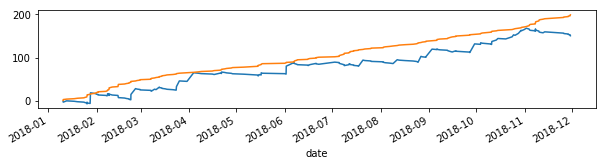

In [85]:
#bb = bets[(bets['nb']==1) & (bets['odds_ref'] > 1) & (bets['odds_ref'] > bets['final_odds_ref_offline']) & (bets['odds_ref'] < 20) & (bets['sub_category']!='kCOURSE_A_CONDITIONS') & (bets['pred'] > 1) & (bets['pred'] < 200) & (bets['target']!='final_odds_ref')   ].copy()

bb = bets[(bets['nb']==1) & (bets['odds_ref'] > 3) & (bets['odds_ref'] > bets['final_odds_ref_offline']) & (bets['odds_ref'] < 20) & (bets['sub_category']!='kCOURSE_A_CONDITIONS') & (bets['pred'] > 2) & (bets['pred'] < 200) & (bets['target']=='pred_knn_2_1')   ].copy()


#bb = bb.groupby('id').filter(lambda b: len(b) <3 )
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_stacked_mlp_relu_1') & (bets['odds_ref']<30) & (bets['odds_ref']>10) & (bets['pred']>0)]
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_knn_2_1') & (bets['odds_ref']<10) & (bets['odds_ref']>3) & (bets['pred']>0.1)]
#bb = bets[ (bets['country']!='dFRA') & (bets['sub_category']!='dNATIONALE_AUTOSTART') & (bets['nb']==1) & (bets['target']!='kpred_knn_1_1') & (bets['pred']>0.) & (bets['odds_ref']<10) & (bets['odds_ref']>1)  ].copy()


# ok
#bb = bets[ (bets['country']!='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=bets['odds_3']) & (bets['odds_ref']<20) & (bets['target']=='pred_knn_10_2') ].copy()


#bb = bets[ (bets['country']!='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']>=3) & (bets['nb']<=3) & (bets['odds_ref']>=bets['odds_1']) & (bets['odds_ref']<20) & (bets['target']=='pred_stacked_mlp_sigmoid_1') ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']=='AUTOSTART') & (bets['nb']<=0) & (bets['odds_ref']>=0) & (bets['odds_ref']<20) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & ( (bets['target']=='pred_knn_10_1') | (bets['target']=='pred_minus_ref_lasso_1') ) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()        
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].count() == 2)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
#bb['profit'] = bb['profit'] * 1/(1+bb['nb'])
#bb['bet'] = bb['bet'] * 1/(1+bb['nb'])

#bb['profit'] = bb['profit'] * bb['pred']
#bb['bet'] = bb['bet'] * bb['pred']

graph_bb(bb, 'sub_category')




In [34]:
bb[bb['declared_player_count']<10]['profit'].mean()


-0.4636363636363636

In [35]:
program.df['category'].value_counts()

PLAT            14201
STEEPLECHASE      435
HAIE              323
Name: category, dtype: int64

In [36]:
mode = 'INTERNET'
mode.lower()

'internet'